# 1.0 Introduction
- Here in this notebook, we build a food vision app - powered by Deep Learning. This app will be deployed using Gradio to end users.
- We experiment two state of the art models - ViT, and EfficientNet. In the spirit of transfer learning, we'll be able to do more with less.
- Of the two models, will deploy the best of the two models (speed, size, and performance).

*Let's get to work!!*

##1.1 Import the libraries we need

In [ ]:
# import torch
# from torch import nn

# from torchvision import datasets

# #for path
# from pathlib import Path


## 1.2 Get the data we need

### 1.2.1 Get the datasets

In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset


from pathlib import Path
from typing import Tuple

DATA_DIR = "data"
Path(DATA_DIR).mkdir(parents=True, exist_ok=True)
def get_datasets(train_transform:transforms,
                 test_transform:transforms) -> Tuple[Dataset, Dataset]:
  train_ds = datasets.Food101(root=DATA_DIR,
                              split='train',
                              transform=train_transform,
                              target_transform=None,
                              download=True
                              )
  test_ds = datasets.Food101(root=DATA_DIR,
                              split='test',
                              transform=test_transform,
                              target_transform=None,
                              download=True
                              )

  return train_ds, test_ds

### 1.2.2 Getting certain percentage of dataset
- e.g 30% so as to get results faster, and experiment more efficiently, since we don't need to wait for our model to train on 100% of our data so as to know we are wrong

In [ ]:
import torch
from torch.utils.data import Dataset, random_split
from typing import Tuple

def get_x_percent_data(train_dataset:Dataset,
                       test_dataset:Dataset,
                       percentage:float = 0.2) -> Tuple[Dataset, Dataset]:

  """
  Function splits the dataset based on percentage argument

  Args:
    train_dataset(torch.utils.data.Dataset) : the training dataset
    test_dataset(torch.utils.data.Dataset) : the test dataset
    percetage(float): the random split value should be a decimal e.g. 0.2 for 20%

  Returns:
    train_ds(Dataset):the train split dataset
    test_ds(Dataset): the test split dataset
  """

  total_train_size = len(train_dataset)
  subset_train_size = int(total_train_size * percentage)
  print(f"total_train_size: {total_train_size} | subset_train_size: {subset_train_size}")

  total_test_size = len(test_dataset)
  subset_test_size = int(total_test_size * percentage)
  print(f"total_test_size: {total_test_size} | subset_train_size: {subset_test_size}")

  train_x_percent, _ = random_split(train_dataset, [subset_train_size, (total_train_size - subset_train_size)])
  test_x_percent, _ = random_split(test_dataset, [subset_test_size, (total_test_size - subset_test_size)])


  return train_x_percent, test_x_percent

### 1.2.2 Get the dataloaders

In [ ]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
def get_dataloaders(train_dataset: Dataset,
                    test_dataset:Dataset,
                    device:torch.device,
                    batch_size: int=32):

  """
  Returns
    train_dataloader
    test_dataloader
  """

  train_data_loader = DataLoader(dataset=train_dataset,
                                batch_size=batch_size,
                                shuffle=True)
  test_data_loader = DataLoader(dataset=test_dataset,
                                batch_size=batch_size,
                                shuffle=False)

  return train_data_loader, test_data_loader



### 1.2.3 Set Data Agnostic code and Helper functions

In [ ]:
import torch
import random
def get_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  return device

def accuracy_fn(y_pred:torch.Tensor, y_true:torch.Tensor):
  correct = torch.eq(y_pred, y_true).sum().item()
  acc = correct/len(y_pred)
  return acc * 100

def plot_sample_images(train_dataset, k=9):
  class_names = train_dataset.classes
  sample_images_indxs =random.sample(range(len(train_dataset)), k)


  nrows = int(k / 3)
  ncols = 3
  figure =plt.figure(figsize=(8, 5))

  for i, index in enumerate(sample_images_indxs):
    figure.add_subplot(nrows, ncols, i+1)
    img, label = train_dataset[index]
    title = f"Label: {class_names[label]}"
    plt.imshow(img.permute(1, 2, 0))
    plt.title(title)
    plt.axis(False)

  plt.show()

def plot_model_results(model_results):
  """
  plot the model results
  """
  fig = plt.figure(figsize=(12, 7)) # Corrected figsize to be a tuple
  fig.add_subplot(1, 2, 1)
  plt.suptitle("Training vs. Test")
  plt.plot(model_results["train_loss"], label="Train")
  plt.plot(model_results["test_loss"], label="Test")
  plt.legend()
  # plt.axis(False) # Removed this line to show axes
  plt.title("Train Loss vs. Test Loss")
  plt.xlabel("Epoch")
  plt.ylabel("Loss")

  fig.add_subplot(1, 2, 2)
  plt.plot(model_results["train_acc"], label="Train")
  plt.plot(model_results["test_acc"], label="Test")
  plt.legend()
  # plt.axis(False) # Removed this line to show axes
  plt.title("Train Acc vs. Test Acc")
  plt.xlabel("Epoch")
  plt.ylabel("Acc")
  # plt.show() # Added plt.show() to display the figure
  return plt

## 2.1 Building `train_model()` custom function

In [ ]:
import torch
from tqdm.auto import tqdm


def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer,
               accuracy_fn,
               device:torch.device):

  #using pytorch 2.0 `with device` context manager
  # with torch.device(device):
  model.to(device)

  #turn model train mode
  model.train()

  #track training loss, and training acc
  train_loss, train_acc = 0, 0
  #iterate through the batches
  for X_train, y_train in dataloader:
    #perfrom a forward pass
    X_train, y_train = X_train.to(device), y_train.to(device)
    y_pred = model(X_train)

    #evaluate loss
    loss =loss_fn(y_pred, y_train)

    #accumulate loss
    train_loss += loss.item()

    #accumulate accuracy
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y_train)

    #zero grad
    optimizer.zero_grad()

    #perform backpropagation
    loss.backward()

    #optimize gradients
    optimizer.step()

    #average train_acc, and train_loss for all the batches
  train_acc /= len(dataloader)
  train_loss /= len(dataloader)


  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader:torch.utils.data.DataLoader,
              loss_fn:torch.nn.Module,
              accuracy_fn,
              device:torch.device):

  #within torch.device context manager
  # with torch.device(device):
  #turn inference mode
  with torch.inference_mode():

    #turn the model mode to eval
    model.eval()

    #track test loss, test acc
    test_loss, test_acc = 0, 0

    #batch loop
    for X_test, y_test in dataloader:
      #forward pass
      X_test, y_test = X_test.to(device), y_test.to(device)
      y_pred =  model(X_test)

      #evaluate the loss
      loss = loss_fn(y_pred, y_test)

      #accumulate loss
      test_loss += loss.item()

      #accumulate accuracy
      test_acc += accuracy_fn(y_pred.argmax(dim=1), y_test)


    #average test loss and acc
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

  return test_loss, test_acc

# train model function
def train_model(model:torch.nn.Module,
                train_dataloader: torch.utils.data.DataLoader,
                test_dataloader: torch.utils.data.DataLoader,
                loss_fn:torch.nn.Module,
                optimizer:torch.optim.Optimizer,
                accuracy_fn,
                device:torch.device,
                epochs = 5
                ):

  #track model results
  model_results = {"train_loss":[],
                   "train_acc":[],
                   "test_loss":[],
                   "test_acc":[]
                   }

  #iterate through epochs
  for epoch in tqdm(range(epochs)):
    #perform train_step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       accuracy_fn=accuracy_fn,
                                       device=device)
    #append the results
    model_results["train_loss"].append(train_loss)
    model_results["train_acc"].append(train_acc)

    #perform test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn,
                                    accuracy_fn=accuracy_fn,
                                    device=device)

    #append the test results
    model_results["test_loss"].append(test_loss)
    model_results["test_acc"].append(test_acc)

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} Train Acc: {train_acc:.2f} | Test Loss {test_loss:.4f} Test Acc: {test_acc:.2f}")

  return model_results


### 2.1.1 Building `model_eval()` function

In [ ]:
def eval_model(model: torch.nn.Module,
               test_data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device:torch.device):
  """
  Returns a dictionary containing the results model predicting on data loader
  """
  loss, acc = 0, 0
  batches_no = len(test_data_loader)
  model.eval()
  with torch.inference_mode():
    for X, y in tqdm(test_data_loader):
      #make predictions
      X, y = X.to(device), y.to(device)

      y_pred = model(X)

      #accumulate loss and accuracy per batch
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y, y_pred.argmax(dim=1))

    #average loss and accuracy
    loss /= batches_no
    acc /= batches_no

  return {"model_name": model.__class__.__name__,
          "model_loss":loss.item(),
          "model_acc":acc}

# 3.0 Building our Models

## 3.1 EfficientNet Model

In [ ]:

import torch
from torch import nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

def createEffNetModel(device:torch.device):
  # with torch.device(device):
  #number of classes
  number_of_classes = 101

  #get the pretrained weights
  weights = EfficientNet_V2_S_Weights.DEFAULT

  #get the transforms used for the pre-trained model
  effNetTransforms = weights.transforms()
  #instantiate the model with the pre-trained weights
  model = efficientnet_v2_s(weights=weights)

  #freeze the weights of the feature extraction layers
  for param in model.features.parameters():
    param.requires_grad = False

  #adjust the classification head to have only 101 classes instead of 1000
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=number_of_classes)
  )

  return effNetTransforms, model

In [ ]:
effNet_transforms, effNetModel = createEffNetModel(device=get_device())
effNet_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
effNet_transforms

ImageClassification(
    crop_size=[384]
    resize_size=[384]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [ ]:
import torch
import matplotlib.pyplot as plt
from PIL import Image
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

# image_tensor = torch.randint(0, 255, size=[1, 3, 500, 500]) / 255
# image_tensor.shape
# plt.imshow(image_tensor.squeeze().permute(1, 2, 0))
effnet_summary = summary(model=effNetModel, input_size=[1, 3, 500, 500])
effNetModel.total_params = effnet_summary.total_params
effNetModel.total_params

20306869

In [ ]:
train_ds, test_ds = get_datasets(train_transform=effNet_transforms,
                                    test_transform=effNet_transforms)


In [ ]:
train_ds, test_ds

(Dataset Food101
     Number of datapoints: 75750
     Root location: data
     split=train
     StandardTransform
 Transform: ImageClassification(
                crop_size=[384]
                resize_size=[384]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ),
 Dataset Food101
     Number of datapoints: 25250
     Root location: data
     split=test
     StandardTransform
 Transform: ImageClassification(
                crop_size=[384]
                resize_size=[384]
                mean=[0.485, 0.456, 0.406]
                std=[0.229, 0.224, 0.225]
                interpolation=InterpolationMode.BILINEAR
            ))

In [ ]:
#get 40% of the data
train_ds_40_percent, test_ds_40_percent = get_x_percent_data(train_dataset=train_ds,
                   test_dataset=test_ds,
                   percentage=0.4)


total_train_size: 75750 | subset_train_size: 30300
total_test_size: 25250 | subset_train_size: 10100


In [ ]:
train_dataloader, test_dataloader = get_dataloaders(train_dataset=train_ds_40_percent,
                                                      test_dataset=test_ds_40_percent,
                                                      batch_size=256,
                                                    device=get_device())
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f383434a180>,
 <torch.utils.data.dataloader.DataLoader at 0x7f383434a1b0>)

In [ ]:
# imgs, labels = next(iter(train_dataloader))
# imgs.shape, labels.shape
# imgs.device

In [ ]:
imgs, labels = train_ds[0]
imgs.shape, labels

(torch.Size([3, 384, 384]), 23)

In [ ]:
next(iter(effNetModel.parameters())).device

device(type='cuda', index=0)

### 3.1.2 Visualize sample images

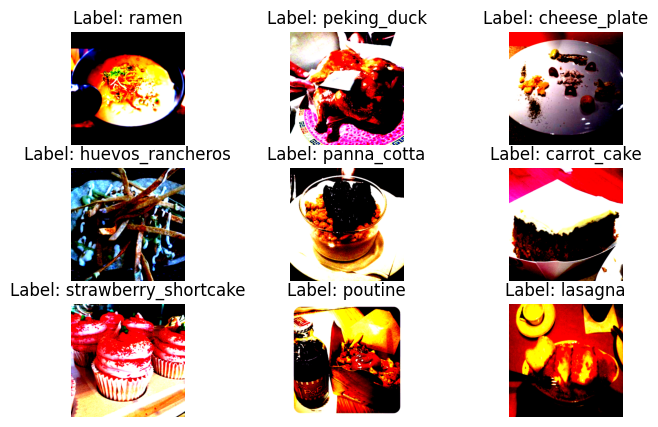

In [ ]:
plot_sample_images(train_ds, 9)

## 3.2 Training EfficientNetV2 model

In [ ]:
import torch

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=effNetModel.classifier.parameters(), lr=1e-1)

effNetModel.results = train_model(model=effNetModel,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=get_device(),
            epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 8.8638 Train Acc: 38.67 | Test Loss 6.7018 Test Acc: 48.49
Epoch: 1 | Train loss: 8.3127 Train Acc: 44.35 | Test Loss 6.7291 Test Acc: 50.44
Epoch: 2 | Train loss: 8.3974 Train Acc: 45.99 | Test Loss 7.0236 Test Acc: 51.70
Epoch: 3 | Train loss: 8.5575 Train Acc: 47.39 | Test Loss 7.4230 Test Acc: 52.27
Epoch: 4 | Train loss: 8.7943 Train Acc: 48.42 | Test Loss 7.8719 Test Acc: 53.01


### 3.2.1 Visualize loss and accuracy over epochs


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

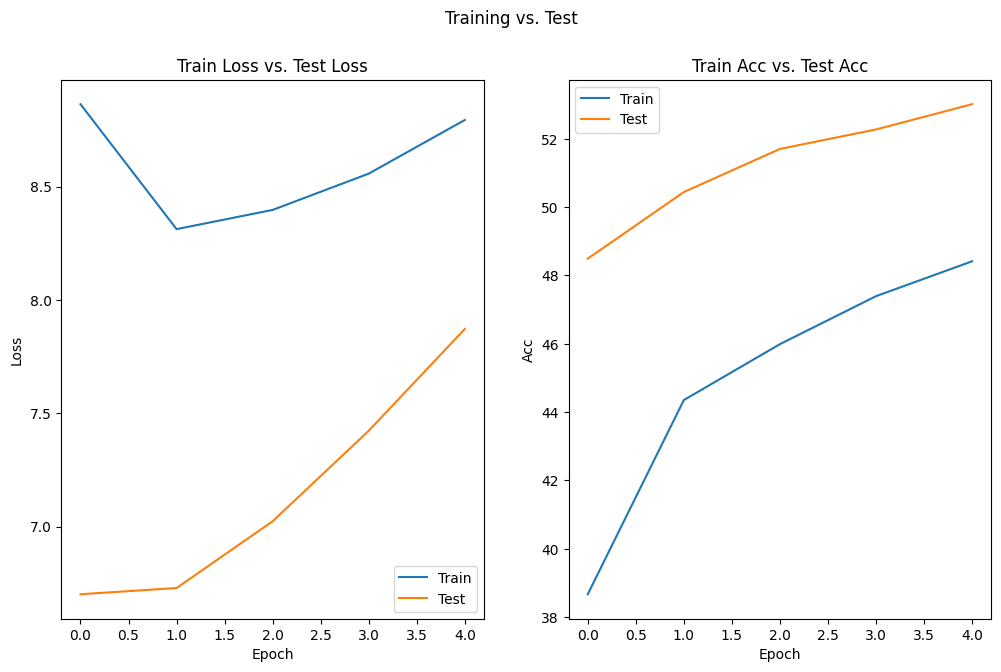

In [ ]:
from pathlib import Path
from google.colab import files
RES_DIR = Path("results")
RES_DIR.mkdir(parents=True, exist_ok=True)
PLT_PATH = RES_DIR /"effnet_model_training_results.png"
plt = plot_model_results(effNetModel.results)
plt.savefig(PLT_PATH)


files.download(PLT_PATH)




### 3.2.3 Evaluate Model

In [ ]:
eval_model(model=effNetModel,
           test_data_loader=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn,
           device=get_device())

  0%|          | 0/40 [00:00<?, ?it/s]

{'model_name': 'EfficientNet',
 'model_loss': 7.871920108795166,
 'model_acc': 53.012526939655174}

### 3.2.4 Save and download the Model

In [ ]:
### Save Model
from pathlib import Path
from google.colab import files
import torch

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODELS_DIR / "effnet_model.pth"
torch.save(effNetModel.state_dict(),MODEL_PATH)

files.download(MODEL_PATH)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 4.0 Training ViT Model

In [ ]:
import torch
from torch import nn
from torchvision.models import vit_b_32, ViT_B_32_Weights

def createViTModel(device:torch.device):
  # with torch.device(device):
  #number of classes
  number_of_classes = 101

  #get the pretrained weights
  weights = ViT_B_32_Weights.DEFAULT

  #get the transforms used for the pre-trained model
  vit_transforms = weights.transforms()
  #instantiate the model with the pre-trained weights
  model = vit_b_32(weights=weights)

  #freeze the weights of the feature extraction layers
  for param in model.parameters():
    param.requires_grad = False

  # #adjust the classification head to have only 101 classes instead of 1000
  model.heads = nn.Sequential(
      nn.Linear(in_features=768, out_features=number_of_classes)
  )

  model = torch.compile(model)

  return vit_transforms, model

In [ ]:
transforms_pre_trained, vit_model = createViTModel(device=get_device())
vit_model.heads
transforms_pre_trained

Downloading: "https://download.pytorch.org/models/vit_b_32-d86f8d99.pth" to /root/.cache/torch/hub/checkpoints/vit_b_32-d86f8d99.pth


100%|██████████| 337M/337M [00:01<00:00, 199MB/s]


ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

### 4.1.1 Get datasets based on pretrained model transforms
- We notice the ViT transformer is overfitting.
1. we could trivial augumentation to reduce overfitting
2. label smoothing to prevent overconfidence

In [ ]:
#add augmentation
from torchvision import transforms
train_transforms_with_ag = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms_pre_trained]
)
train_ds, test_ds = get_datasets(train_transform=transforms_pre_trained,
                                    test_transform=transforms_pre_trained)

#get 20% of the data
train_ds_40_percent, test_ds_40_percent = get_x_percent_data(train_dataset=train_ds,
                                                            test_dataset=test_ds,
                                                            percentage=0.4)

total_train_size: 75750 | subset_train_size: 30300
total_test_size: 25250 | subset_train_size: 10100


In [ ]:
train_dataloader, test_dataloader = get_dataloaders(train_dataset=train_ds_40_percent,
                                                      test_dataset=test_ds_40_percent,
                                                      batch_size=64,
                                                    device=get_device())
train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f3834471430>,
 <torch.utils.data.dataloader.DataLoader at 0x7f3825f5f740>)

In [ ]:
next(iter(vit_model.parameters())).device

device(type='cpu')

In [ ]:
import torch

# Enable TensorFloat32 for potentially better performance on supported hardware
torch.set_float32_matmul_precision('high')

loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(params=vit_model.heads.parameters(), lr=1e-1)

vit_model.results = train_model(model=vit_model,
            train_dataloader=train_dataloader,
            test_dataloader=test_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_fn,
            device=get_device(),
            epochs=5)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0 | Train loss: 23.0791 Train Acc: 46.31 | Test Loss 24.2742 Test Acc: 46.71
Epoch: 1 | Train loss: 22.1469 Train Acc: 50.40 | Test Loss 25.1165 Test Acc: 48.14
Epoch: 2 | Train loss: 21.6836 Train Acc: 53.06 | Test Loss 26.0894 Test Acc: 47.71
Epoch: 3 | Train loss: 21.4918 Train Acc: 54.80 | Test Loss 28.0259 Test Acc: 46.03
Epoch: 4 | Train loss: 21.8557 Train Acc: 55.22 | Test Loss 28.1267 Test Acc: 47.54


### 4.1.2 Visualize Loss, and Accuracy


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

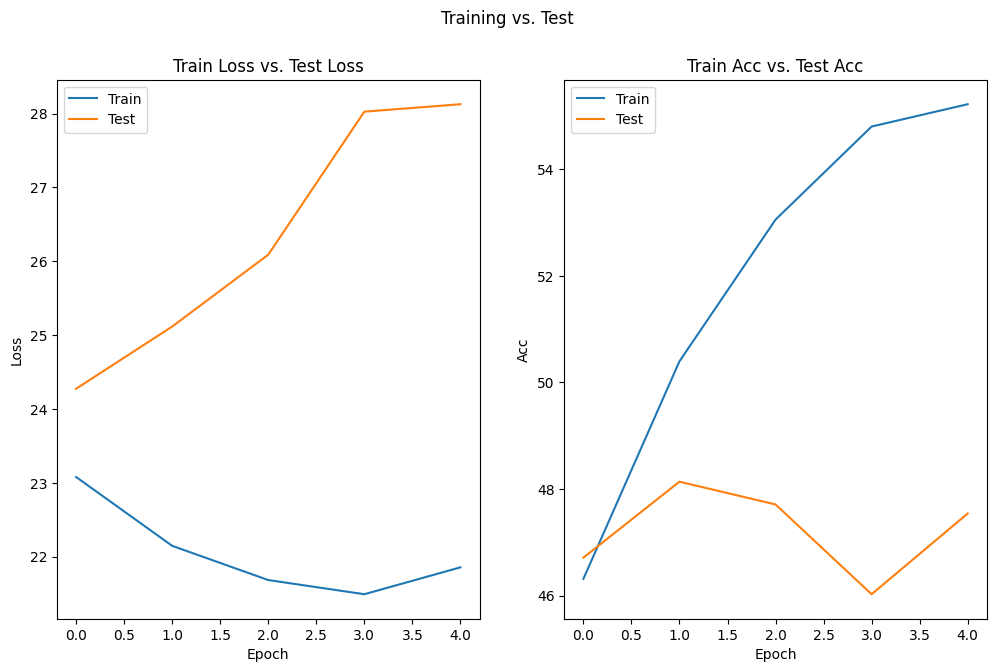

In [ ]:
from pathlib import Path
from google.colab import files
RES_DIR = Path("results")
RES_DIR.mkdir(parents=True, exist_ok=True)
PLT_PATH = RES_DIR /"vit_model_training_results.png"
plt = plot_model_results(vit_model.results)
plt.savefig(PLT_PATH)


files.download(PLT_PATH)


###4.1.3 Evaluate Model Accuracy


In [ ]:
eval_model(model=vit_model,
           test_data_loader=test_dataloader,
           loss_fn=loss_fn,
           accuracy_fn=accuracy_fn,
           device=get_device())

  0%|          | 0/158 [00:00<?, ?it/s]

{'model_name': 'OptimizedModule',
 'model_loss': 28.12665367126465,
 'model_acc': 47.540621957156766}

### 4.1.4 Save and download the Model

In [ ]:
### Save Model
from pathlib import Path
from google.colab import files
import torch

MODELS_DIR = Path("models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)
MODEL_PATH = MODELS_DIR / "vit_model.pth"
torch.save(vit_model.state_dict(),MODEL_PATH)

files.download(MODEL_PATH)

NameError: name 'vit_model' is not defined

## 5.0 Deploying our best model

### 5.1.1 Downloading and Importing Gradio

In [ ]:
try:
  import gradio as gr
except:
  !pip install gradio
  import gradio as gr

print(f"Gradio version: {gr.__version__}")

Gradio version: 5.42.0


### 5.1.2 Setting up demos directory

In [ ]:
import shutil
from pathlib import Path

#create food vision path
food_vision_path = Path("demos/food-vision")

if food_vision_path.exists():
  shutil.rmtree(food_vision_path)
  food_vision_path.mkdir(parents=True, exist_ok=True)
else:
  food_vision_path.mkdir(parents=True, exist_ok=True)

(food_vision_path/"examples").mkdir(parents=True, exist_ok=True)



### 5.1.3 Creating `model.py`

In [ ]:
%%writefile demos/food-vision/models.py

import torch
from torch import nn
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

def createEffNetModel(device:torch.device):
  # with torch.device(device):
  #number of classes
  number_of_classes = 101

  #get the pretrained weights
  weights = EfficientNet_V2_S_Weights.DEFAULT

  #get the transforms used for the pre-trained model
  effNetTransforms = weights.transforms()
  #instantiate the model with the pre-trained weights
  model = efficientnet_v2_s(weights=weights)

  #freeze the weights of the feature extraction layers
  for param in model.features.parameters():
    param.requires_grad = False

  #adjust the classification head to have only 101 classes instead of 1000
  model.classifier = nn.Sequential(
      nn.Dropout(p=0.2, inplace=True),
      nn.Linear(in_features=1280, out_features=number_of_classes)
  )

  return effNetTransforms, model

Overwriting demos/food-vision/models.py


### 5.1.2 Our Predict Function

In [ ]:
from typing import Tuple, Dict
import torch
from torchvision import transforms
from timeit import default_timer as timer
from models import createEffNetModel
def predict(img) -> Tuple[Dict, float]:
  #start a timer
  start_time = timer()


  #load the saved effnet model
  # effNetModel.to("cpu")
  # print(next(iter(effNetModel.parameters())).device)

  effNet_transforms, effNetModel = createEffNetModel(device="cpu")

  #transform image
  transformed_img = effNet_transforms(img).unsqueeze(0) #add batch dimension on zero index
  effNetModel.load_state_dict(torch.load("models/effnet_model.pth"))
  effNetModel.eval()
  train_ds, test_ds = get_datasets(effNet_transforms, effNet_transforms)
  class_names = train_ds.classes
  with torch.inference_mode():
    pred_probs = effNetModel(transformed_img).softmax(dim=1)

  pred_labels_and_prob = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #remove underscores
  formatted_dict = {key.replace("_", " "): value for key, value in pred_labels_and_prob.items()}

  #end timer
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return formatted_dict, pred_time


### 5.1.3 Writing classnames into a  `class_names.txt`

In [ ]:

effNetTransforms, _ = createEffNetModel(device="cpu")
train_ds, test_ds = get_datasets(effNetTransforms, effNetTransforms)
class_names = train_ds.classes
# !mv models/effnet_model.pth demos/food-vision
with open("demos/food-vision/class_names.txt", "w")  as file:
  file.write("\n".join(class_names))

100%|██████████| 5.00G/5.00G [02:24<00:00, 34.6MB/s]


### 5.1.4 Creating `app.py` - the gradio app

In [ ]:
%%writefile demos/food-vision/app.py

import gradio as gr
import os
from typing import Tuple, Dict
import torch
from torchvision import transforms
from timeit import default_timer as timer
from models import createEffNetModel

#set up class names
with open("demos/food-vision/class_names.txt", "r") as file:
  class_names = [food.strip() for food in file.readlines()]

#model and transforms preparation
effNet_transforms, effNetModel = createEffNetModel(device="cpu")

#load saved model and the weights
effNetModel.load_state_dict(
    f=torch.load("models/effnet_model.pth", map_location="cpu"))

def predict(img) -> Tuple[Dict, float]:
  #start a timer
  start_time = timer()
  #transform image
  transformed_img = effNet_transforms(img).unsqueeze(0) #add batch dimension on zero index
  #set to eval mode
  effNetModel.eval()
  with torch.inference_mode():
    pred_probs = effNetModel(transformed_img).softmax(dim=1)

  pred_labels_and_prob = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

  #remove underscores
  formatted_dict = {key.replace("_", " "): value for key, value in pred_labels_and_prob.items()}

  #end timer
  end_time = timer()
  pred_time = round(end_time - start_time, 4)

  return formatted_dict, pred_time

#gradio app
title = "Food Vision App 🍉🍓🍕"
description="A deep learning app based on [EfficientNetV2](https://docs.pytorch.org/vision/0.21/models/efficientnetv2.html) that predicts the class of an image"
article="Created at [Google Colab Notebook](https://colab.research.google.com/drive/1Te2wElAzKtidJuHxi7Xgy7OM6PKZJvgL?usp=sharing)"
demo = gr.Interface(fn=predict, #map inputs to outputs
                    inputs=gr.Image(type="pil"),
                    outputs=[
                        gr.Label(num_top_classes=3, label="prediction"),
                        gr.Number(label="Prediction time (s)")
                        ],
                    examples=["steak.jpg", "test2.jpg", "test3.jpg", "test4.jpg"],
                    title=title,
                    description=description,
                    article=article
                    )
#launch the demo
demo.launch(debug=False,share=True)

Writing demos/food-vision/app.py


FileNotFoundError: [Errno 2] No such file or directory: 'demos/food-vision/app.py'

Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth


100%|██████████| 82.7M/82.7M [00:00<00:00, 207MB/s]
100%|██████████| 5.00G/5.00G [03:36<00:00, 23.1MB/s]


In [ ]:
!ls demos/food-vision

class_names.txt  examples


### 5.1.5 creating `requirements.txt`

In [ ]:
%%writefile demos/food-vision/requirements.txt
torch=2.8.0+cu126
torchvision=0.23.0+cu126
gradio=5.42.0

Writing demos/food-vision/requirements.txt


### 5.1.6 Zipping and Downloading Foodvision

In [ ]:
!cd demos/food-vision && zip -r ../foodvision_app.zip * -x  "*.pyc" "*.ipynb_checkpoints*" "*.ipynb" "*__pycache__*"

  adding: app.py (deflated 52%)
  adding: class_names.txt (deflated 48%)
  adding: examples/ (stored 0%)
  adding: examples/test2.jpg (deflated 0%)
  adding: examples/test3.jpg (deflated 0%)
  adding: examples/test1.jpg (deflated 0%)
  adding: model.py (deflated 52%)
  adding: requirements.txt (deflated 14%)


In [ ]:
from google.colab import files
files.download("demos/foodvision_app.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>